In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Aug_15_21:14:11_PDT_2021
Cuda compilation tools, release 11.4, V11.4.120
Build cuda_11.4.r11.4/compiler.30300941_0


In [4]:
### For Colab, install dependencies.

# !pip install -U mxnet-cu101==1.7 
# !pip uninstall mxnet-cu101
# !pip install --upgrade mxnet==1.8
# !pip install gluonts
# !pip install fredapi
# !pip install stats-can
# !pip install --upgrade scikit-learn

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
# %cd /content/drive/MyDrive/Colab Notebooks/foodprice-forecasting
# !pwd

In [7]:
import pandas as pd
pd.set_option('precision', 3)
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

import numpy as np
import pickle
import data

import importlib
importlib.reload(data)

from data import update_expl_data, update_target_data, food_categories, preprocess_expl
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

import mxnet as mx
from gluonts.model.n_beats import NBEATSEnsembleEstimator
from gluonts.mx import Trainer
from gluonts.evaluation import make_evaluation_predictions

In [8]:
"""
Set sample rate. In this notebook, all data will be resampled at the chosen frequency.
'MS' : Monthly (Month Start)
'W' : Weekly
'D' : Daily
"""

year_period = {'MS': 12, 'W': 52, 'D': 365}
frequency = 'MS'
one_year = year_period[frequency]
output_path = "./output/nbeatsfredvars_202110"
if not os.path.exists(output_path):
    os.mkdir(output_path)

## Load Data Using APIs

In [9]:
"""
Load food CPI data from January 1986 to the most recently available data.
"""

foodprice_df = update_target_data(food_categories, './data_files/food_cpi.csv')
foodprice_df = foodprice_df.resample(frequency).mean().interpolate()
foodprice_df

,Bakery and cereal products (excluding baby food),Dairy products and eggs,"Fish, seafood and other marine products",Food purchased from restaurants,Food,"Fruit, fruit preparations and nuts",Meat,Other food products and non-alcoholic beverages,Vegetables and vegetable preparations
REF_DATE,,,,,,,,,
1986-01-01,69.3,70.9,60.6,59.1,67.3,76.0,65.1,77.5,76.0
1986-02-01,70.3,70.8,61.3,59.1,66.9,77.6,64.2,78.1,68.4
1986-03-01,70.6,71.1,61.3,59.3,67.0,79.2,64.2,78.6,66.2
1986-04-01,71.3,71.0,61.4,59.7,67.7,82.2,63.6,79.5,71.1
1986-05-01,71.2,71.4,61.9,59.9,68.2,83.5,64.0,79.8,75.3
...,...,...,...,...,...,...,...,...,...
2021-05-01,157.8,146.6,147.6,163.5,156.6,143.9,175.4,141.6,153.8
2021-06-01,157.7,145.3,146.2,163.9,156.8,144.5,176.7,142.2,153.4
2021-07-01,157.9,146.4,146.6,165.2,157.6,141.7,180.9,141.9,154.8


In [10]:
"""
Load exogenous/auxiliary explanatory variables from FRED: https://fred.stlouisfed.org/
These data sources reflect various economic factors that may improve forecasts. 
Please visit the FRED website to learn more about these series, and to find others
that may be useful for food CPI forecasting. 
"""

data_sources = ["DEXCAUS",
                "DCOILWTICO",
                "WILL5000IND",
                "VXOCLS",
                "CUSR0000SAF112",
                "CUSR0000SAF113",
                "CPIFABSL",
                "UNRATE",
                "FEDFUNDS",
                "IRLTLT01CAM156N",
                "LRUNTTTTCAM156S",
                "CPALCY01CAM661N",
                "CPGRLE01CAM657N",
                "QCAR368BIS"
               ]

other_fred_sources = pd.read_csv("./FRED_series_names.csv")['0'].to_list()
data_sources = data_sources + [s for s in other_fred_sources if s not in data_sources]

# expl_df = preprocess_expl(update_expl_data(data_sources, './data_files/expl_vars.csv', sleep_sec=0.5))

expl_df = pd.read_csv("./data_files/expl_vars.csv")
expl_df = expl_df.set_index("Unnamed: 0")
expl_df.index = pd.DatetimeIndex(expl_df.index)
# expl_df

expl_df_monthly = expl_df.resample(frequency).mean().interpolate()
expl_df_monthly

,DEXCAUS,DCOILWTICO,WILL5000IND,VXOCLS,CUSR0000SAF112,CUSR0000SAF113,CPIFABSL,UNRATE,FEDFUNDS,IRLTLT01CAM156N,...,XTIMVA01CAM657S,XTIMVA01CAM659S,XTIMVA01CAM664N,XTIMVA01CAM664S,XTIMVA01CAM667S,XTNTVA01CAM664N,XTNTVA01CAM664S,XTNTVA01CAM667S,TOTALNS,TOTALSL
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
1986-01-01,NaN,NaN,NaN,NaN,102.500,110.400,107.500,6.70,8.140,10.042,...,3.644,12.051,9.368e+09,9.496e+09,6.749e+09,6.906e+08,1.052e+09,7.479e+08,607.369,605.703
1986-02-01,NaN,NaN,NaN,NaN,102.000,105.300,107.400,7.20,7.860,9.967,...,1.965,16.745,9.495e+09,9.632e+09,6.881e+09,-9.880e+07,1.539e+08,1.099e+08,605.807,610.678
1986-03-01,NaN,NaN,NaN,NaN,101.900,105.900,107.600,7.20,7.480,9.402,...,-11.565,1.655,8.803e+09,8.529e+09,6.085e+09,9.138e+08,9.079e+08,6.478e+08,606.799,613.377
1986-04-01,1.392,11.130,5.530,24.700,101.100,107.800,107.800,7.10,6.990,8.848,...,13.334,10.821,1.034e+10,9.569e+09,6.897e+09,3.470e+08,6.563e+08,4.730e+08,614.367,619.658
1986-05-01,1.377,13.800,5.540,21.920,101.200,110.100,108.200,7.20,6.850,8.932,...,-4.236,6.160,9.598e+09,9.091e+09,6.605e+09,7.013e+08,6.893e+08,5.008e+08,621.915,625.820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-01,1.230,64.605,204.510,16.055,273.960,314.528,273.122,5.80,0.060,1.524,...,5.906,68.210,5.023e+10,4.995e+10,4.120e+10,-3.382e+08,-4.385e+08,-3.617e+08,4232.824,4276.989
2021-06-01,1.203,67.800,209.020,16.290,280.756,316.849,275.183,5.90,0.080,1.413,...,-1.193,32.308,5.158e+10,4.974e+10,4.071e+10,3.639e+09,3.230e+09,2.643e+09,4267.642,4315.176
2021-07-01,1.240,75.330,215.210,12.610,283.832,315.740,276.680,5.55,0.085,1.303,...,1.957,18.098,5.101e+10,5.198e+10,4.150e+10,2.321e+08,1.134e+09,9.054e+08,4284.921,4332.450


In [11]:
combined_df = pd.concat((foodprice_df, expl_df_monthly), axis=1).dropna(axis=0)
combined_df

,Bakery and cereal products (excluding baby food),Dairy products and eggs,"Fish, seafood and other marine products",Food purchased from restaurants,Food,"Fruit, fruit preparations and nuts",Meat,Other food products and non-alcoholic beverages,Vegetables and vegetable preparations,DEXCAUS,...,XTIMVA01CAM657S,XTIMVA01CAM659S,XTIMVA01CAM664N,XTIMVA01CAM664S,XTIMVA01CAM667S,XTNTVA01CAM664N,XTNTVA01CAM664S,XTNTVA01CAM667S,TOTALNS,TOTALSL
1986-04-01,71.3,71.0,61.4,59.7,67.7,82.2,63.6,79.5,71.1,1.392,...,13.334,10.821,1.034e+10,9.569e+09,6.897e+09,3.470e+08,6.563e+08,4.730e+08,614.367,619.658
1986-05-01,71.2,71.4,61.9,59.9,68.2,83.5,64.0,79.8,75.3,1.377,...,-4.236,6.160,9.598e+09,9.091e+09,6.605e+09,7.013e+08,6.893e+08,5.008e+08,621.915,625.820
1986-06-01,71.1,71.1,62.0,60.0,68.4,83.1,64.9,79.9,74.1,1.379,...,0.424,2.928,9.696e+09,9.219e+09,6.633e+09,5.973e+08,5.314e+08,3.823e+08,627.891,630.056
1986-07-01,71.7,71.3,62.2,60.6,69.2,84.8,66.5,80.2,75.7,1.380,...,15.840,17.471,9.752e+09,1.061e+10,7.683e+09,-4.890e+08,-9.670e+07,-7.004e+07,633.608,635.151
1986-08-01,71.9,71.5,62.7,60.9,69.5,86.7,67.8,80.2,71.9,1.381,...,-12.819,2.319,8.562e+09,9.300e+09,6.698e+09,9.390e+07,2.959e+08,2.131e+08,640.513,638.904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-01,157.8,146.6,147.6,163.5,156.6,143.9,175.4,141.6,153.8,1.230,...,5.906,68.210,5.023e+10,4.995e+10,4.120e+10,-3.382e+08,-4.385e+08,-3.617e+08,4232.824,4276.989
2021-06-01,157.7,145.3,146.2,163.9,156.8,144.5,176.7,142.2,153.4,1.203,...,-1.193,32.308,5.158e+10,4.974e+10,4.071e+10,3.639e+09,3.230e+09,2.643e+09,4267.642,4315.176
2021-07-01,157.9,146.4,146.6,165.2,157.6,141.7,180.9,141.9,154.8,1.240,...,1.957,18.098,5.101e+10,5.198e+10,4.150e+10,2.321e+08,1.134e+09,9.054e+08,4284.921,4332.450
2021-08-01,158.5,148.3,146.8,165.9,158.0,142.5,182.1,141.7,152.2,1.251,...,-2.648,14.107,5.226e+10,5.090e+10,4.041e+10,1.505e+09,2.960e+09,2.350e+09,4325.642,4346.829


In [12]:
foodprice_df = combined_df  # being lazy for now...

# NBEATS Model and Experiments

## Data Splitting

For each such candidate forecast, we should record any uncertainty/confidence metrics it provides, and evaluation metrics for that same model configuration over the test set. i.e. When model configuration XYZ was used to forecast Meat prices over the test set (with that data not being used for training or validation!) - what were its evaluation metrics on the withheld data? We should report this consistently for ALL EXPERIMENTS. 

For all models, we will use the following "simulated" report dates. This is a form of cross validation over time. We train a model up to each cutoff date, and then produce and evaluate 18-month forecasts. We can then collect each model's validation metric, take the mean, and use this to do model selection for the final forecast (or ensemble of forecasts!).

In [13]:
report_sim_dates = ["2015-07-01", "2016-07-01", "2017-07-01", "2018-07-01", "2019-07-01", "2020-07-01"]

In [14]:
sim_train_dates = {}
sim_valid_dates = {}

for date in report_sim_dates:
    sim_train_dates[date] = foodprice_df.index[foodprice_df.index <= date]
    sim_valid_dates[date] = foodprice_df.index[(foodprice_df.index > date) & (foodprice_df.index <= (pd.to_datetime(date) + pd.DateOffset(months=18)))]

## Fitting and Evaluating a Single NBEATS Model: Example Using All Food Prices

In [15]:
N = foodprice_df.shape[1]
T = foodprice_df.shape[0]
prediction_length = 18
freq = "MS"
dataset = foodprice_df.T.values
start = pd.Timestamp("2016-07-01", freq=freq)

/tmp/ipykernel_65498/56946274.py:6: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  start = pd.Timestamp("2016-07-01", freq=freq)


In [16]:
from gluonts.dataset.common import ListDataset

In [17]:
dataset_df = foodprice_df.T
dataset_df

,1986-04-01,1986-05-01,1986-06-01,1986-07-01,1986-08-01,1986-09-01,1986-10-01,1986-11-01,1986-12-01,1987-01-01,...,2020-12-01,2021-01-01,2021-02-01,2021-03-01,2021-04-01,2021-05-01,2021-06-01,2021-07-01,2021-08-01,2021-09-01
Bakery and cereal products (excluding baby food),7.130e+01,7.120e+01,7.110e+01,7.170e+01,7.190e+01,7.170e+01,7.110e+01,7.160e+01,7.220e+01,7.260e+01,...,1.564e+02,1.542e+02,1.571e+02,1.568e+02,1.562e+02,1.578e+02,1.577e+02,1.579e+02,1.585e+02,1.581e+02
Dairy products and eggs,7.100e+01,7.140e+01,7.110e+01,7.130e+01,7.150e+01,7.180e+01,7.180e+01,7.210e+01,7.250e+01,7.250e+01,...,1.415e+02,1.416e+02,1.431e+02,1.449e+02,1.461e+02,1.466e+02,1.453e+02,1.464e+02,1.483e+02,1.480e+02
"Fish, seafood and other marine products",6.140e+01,6.190e+01,6.200e+01,6.220e+01,6.270e+01,6.310e+01,6.360e+01,6.530e+01,6.590e+01,6.710e+01,...,1.447e+02,1.434e+02,1.439e+02,1.449e+02,1.451e+02,1.476e+02,1.462e+02,1.466e+02,1.468e+02,1.471e+02
Food purchased from restaurants,5.970e+01,5.990e+01,6.000e+01,6.060e+01,6.090e+01,6.090e+01,6.130e+01,6.160e+01,6.170e+01,6.210e+01,...,1.616e+02,1.626e+02,1.629e+02,1.626e+02,1.632e+02,1.635e+02,1.639e+02,1.652e+02,1.659e+02,1.659e+02
Food,6.770e+01,6.820e+01,6.840e+01,6.920e+01,6.950e+01,6.990e+01,7.020e+01,7.060e+01,7.050e+01,7.120e+01,...,1.536e+02,1.550e+02,1.556e+02,1.555e+02,1.554e+02,1.566e+02,1.568e+02,1.576e+02,1.580e+02,1.585e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XTNTVA01CAM664N,3.470e+08,7.013e+08,5.973e+08,-4.890e+08,9.390e+07,1.542e+09,1.262e+09,1.192e+09,1.406e+09,3.872e+08,...,8.227e+08,3.783e+09,2.130e+09,-7.588e+08,-8.233e+08,-3.382e+08,3.639e+09,2.321e+08,1.505e+09,1.505e+09
XTNTVA01CAM664S,6.563e+08,6.893e+08,5.314e+08,-9.670e+07,2.959e+08,1.222e+09,1.165e+09,6.931e+08,8.879e+08,6.596e+08,...,-1.381e+09,2.116e+09,1.767e+09,-9.810e+07,1.340e+09,-4.385e+08,3.230e+09,1.134e+09,2.960e+09,2.960e+09
XTNTVA01CAM667S,4.730e+08,5.008e+08,3.823e+08,-7.004e+07,2.131e+08,8.806e+08,8.390e+08,4.999e+08,6.435e+08,4.850e+08,...,-1.078e+09,1.663e+09,1.392e+09,-7.802e+07,1.072e+09,-3.617e+08,2.643e+09,9.054e+08,2.350e+09,2.350e+09
TOTALNS,6.144e+02,6.219e+02,6.279e+02,6.336e+02,6.405e+02,6.499e+02,6.567e+02,6.569e+02,6.664e+02,6.553e+02,...,4.185e+03,4.177e+03,4.166e+03,4.167e+03,4.188e+03,4.233e+03,4.268e+03,4.285e+03,4.326e+03,4.326e+03


In [18]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

metrics = {
    'r2_score': r2_score,
    'mae': mean_absolute_error,
    'mape': mean_absolute_percentage_error,
    'mse': mean_squared_error,
    'rmse': rmse
}
def get_prophet_df(foodprice_df, food_category, dates):
    df = foodprice_df[food_category][dates]
    df = df.reset_index()
    df = df.rename({'REF_DATE':'ds', food_category:'y'}, axis=1)
    return df

In [19]:
def train_eval_nbeats(report_sim_date):

    report_train_dates = sim_train_dates[report_sim_date]
    report_valid_dates = sim_valid_dates[report_sim_date]
    
    # train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
    train_ds = ListDataset(
        [{'target': x, 'start': start} for x in dataset_df[list(report_train_dates)].values],
        freq=freq
    )

    valid_ds_report = ListDataset(
        [{'target': x, 'start': start} for x in dataset_df[list(report_train_dates) + list(report_valid_dates)].values],
        freq='MS'
    )

    estimator = NBEATSEnsembleEstimator(
        prediction_length=prediction_length,
        #context_length=7*prediction_length,
        meta_bagging_size = 3,  
        meta_context_length = [prediction_length * m for m in [3,5,7]],
        meta_loss_function = ['sMAPE'], 
        num_stacks = 30,
        widths= [512],
        freq="MS",
        trainer=Trainer(
                    # learning_rate=6e-4,
                    #clip_gradient=1.0,
                    epochs=5, # 100
                    num_batches_per_epoch=10, # 200
                    batch_size=16,
                    ctx=mx.context.cpu()
                )

    )

    predictor = estimator.train(train_ds)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=valid_ds_report,  # test dataset
        predictor=predictor,  # predictor
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)
    all_fc_dates = list(report_train_dates) + list(report_valid_dates)

    all_food_metrics = {}
    food_forecasts = {}

    for target_index in range(len(forecasts)):

        # Get food price category
        foodprice_category = foodprice_df.columns[target_index]

        if foodprice_category in food_categories:

            # plot actual
            fig, ax = plt.subplots(figsize=(8,3))
            ax.plot(all_fc_dates, foodprice_df[foodprice_category][all_fc_dates])

            # plot forecast
            forecast_entry = forecasts[target_index]
            ax.plot(report_valid_dates, forecast_entry.mean[:len(report_valid_dates)], color='green')

            plt.title(f"{foodprice_category}, {report_sim_date}")
            plt.grid()
            plt.show()

            fc_metrics = pd.Series({metric_name: metric_fn(y_true=foodprice_df[foodprice_category][report_valid_dates], y_pred=forecast_entry.mean[:len(report_valid_dates)]) for metric_name, metric_fn in metrics.items()})
            print(fc_metrics)

            all_food_metrics[foodprice_category] = fc_metrics
            food_forecasts[foodprice_category] = pd.Series(forecast_entry.mean[:len(report_valid_dates)], index=report_valid_dates, name=foodprice_category)

    all_forecasts = pd.DataFrame(food_forecasts)
    all_forecasts.to_csv(f"{output_path}/forecasts_{report_sim_date}.csv")

    return all_food_metrics, all_forecasts

/home/ethan/anaconda3/envs/forecasting/lib/python3.8/site-packages/gluonts/dataset/common.py:323: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(string, freq=freq)
/home/ethan/anaconda3/envs/forecasting/lib/python3.8/site-packages/gluonts/dataset/common.py:326: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if isinstance(timestamp.freq, Tick):
/home/ethan/anaconda3/envs/forecasting/lib/python3.8/site-packages/gluonts/dataset/common.py:337: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return timestamp.freq.rollforward(timestamp)


TRAINER:gluonts.mx.trainer._base.Trainer(add_default_callbacks=True, batch_size=16, callbacks=None, clip_gradient=10.0, ctx=mxnet.context.Context("cpu", 0), epochs=5, hybridize=True, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=10, patience=10, weight_decay=1e-08)


  0%|          | 0/10 [00:00<?, ?it/s]/home/ethan/anaconda3/envs/forecasting/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/ethan/anaconda3/envs/forecasting/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
  0%|          | 0/10 [00:00<?, ?it/s]/home/ethan/anaconda3/envs/forecasting/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
  0%|          | 0/10 [00:00<?, ?it/s]/home/ethan/anaconda3/envs/forecasting/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future vers

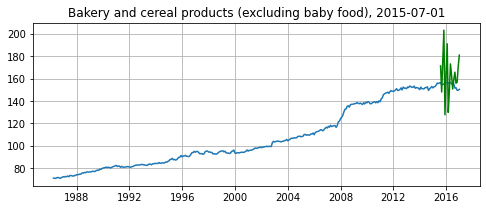

r2_score    -73.804
mae          16.789
mape          0.109
mse         432.304
rmse         20.792
dtype: float64


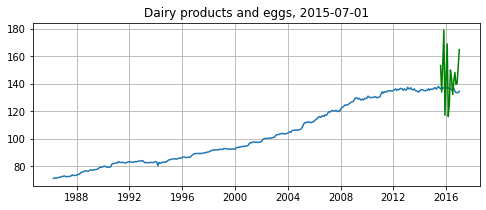

r2_score   -203.904
mae          15.330
mape          0.113
mse         344.922
rmse         18.572
dtype: float64


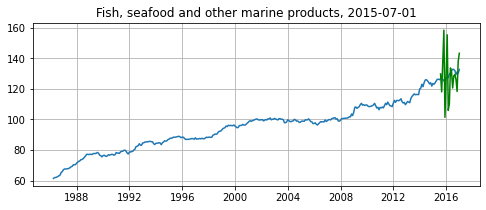

r2_score    -29.787
mae          11.434
mape          0.089
mse         221.375
rmse         14.879
dtype: float64


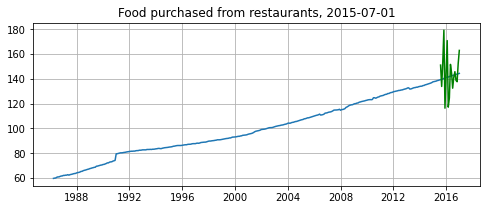

r2_score   -118.783
mae          12.906
mape          0.091
mse         272.103
rmse         16.496
dtype: float64


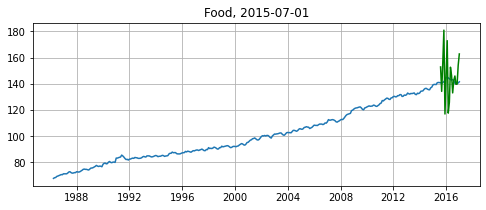

r2_score   -114.645
mae          13.152
mape          0.092
mse         294.408
rmse         17.158
dtype: float64


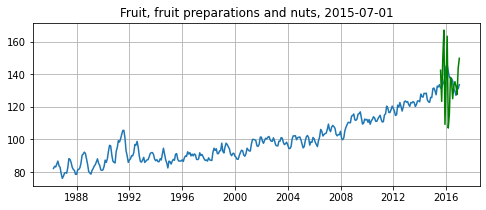

r2_score     -9.884
mae          13.160
mape          0.096
mse         277.686
rmse         16.664
dtype: float64


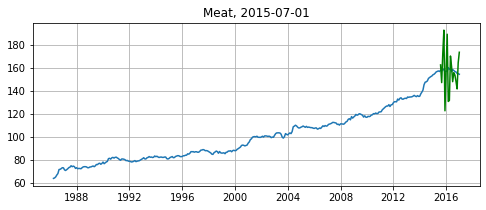

r2_score   -152.422
mae          14.855
mape          0.094
mse         348.248
rmse         18.661
dtype: float64


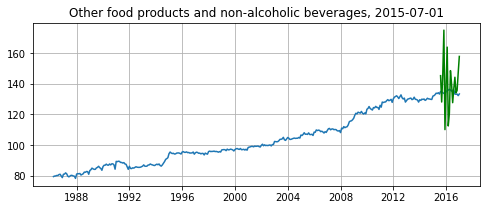

r2_score   -207.383
mae          13.658
mape          0.102
mse         298.560
rmse         17.279
dtype: float64


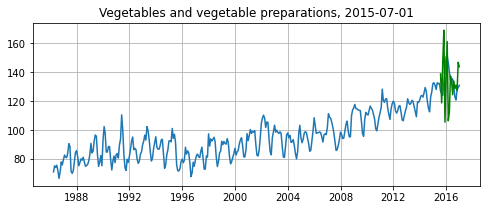

r2_score     -3.714
mae          15.104
mape          0.111
mse         371.035
rmse         19.262
dtype: float64
TRAINER:gluonts.mx.trainer._base.Trainer(add_default_callbacks=True, batch_size=16, callbacks=None, clip_gradient=10.0, ctx=mxnet.context.Context("cpu", 0), epochs=5, hybridize=True, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=10, patience=10, weight_decay=1e-08)


  0%|          | 0/10 [00:00<?, ?it/s]/home/ethan/anaconda3/envs/forecasting/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/ethan/anaconda3/envs/forecasting/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
  0%|          | 0/10 [00:00<?, ?it/s]/home/ethan/anaconda3/envs/forecasting/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
  0%|          | 0/10 [00:00<?, ?it/s]/home/ethan/anaconda3/envs/forecasting/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future vers

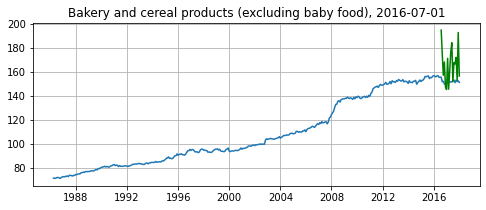

r2_score   -230.860
mae          15.641
mape          0.103
mse         394.477
rmse         19.861
dtype: float64


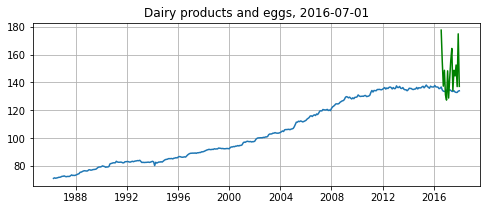

r2_score   -495.703
mae          14.712
mape          0.110
mse         363.820
rmse         19.074
dtype: float64


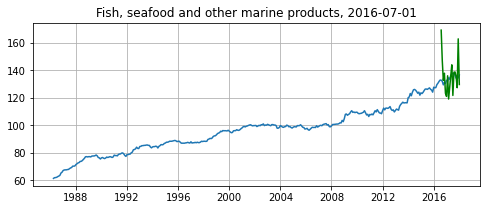

r2_score    -29.309
mae           9.812
mape          0.073
mse         184.060
rmse         13.567
dtype: float64


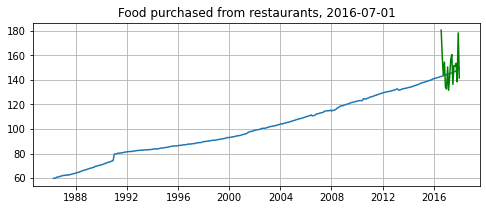

r2_score    -59.763
mae          11.481
mape          0.079
mse         212.416
rmse         14.574
dtype: float64


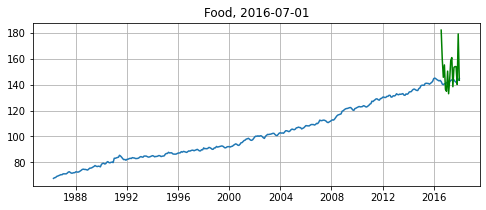

r2_score   -146.179
mae          12.250
mape          0.086
mse         256.132
rmse         16.004
dtype: float64


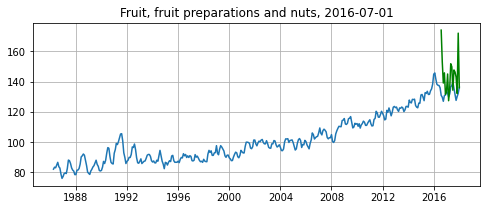

r2_score    -26.996
mae          12.718
mape          0.096
mse         306.816
rmse         17.516
dtype: float64


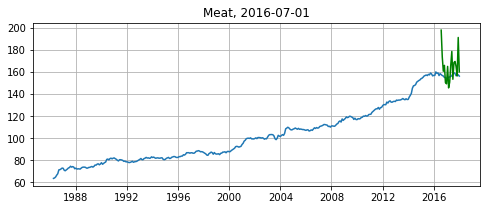

r2_score   -114.140
mae          11.775
mape          0.075
mse         242.975
rmse         15.588
dtype: float64


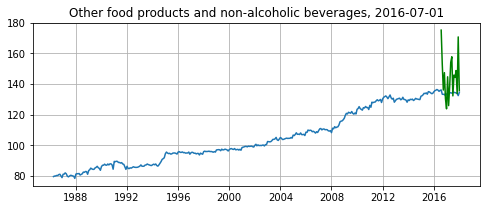

r2_score   -414.594
mae          12.889
mape          0.096
mse         294.366
rmse         17.157
dtype: float64


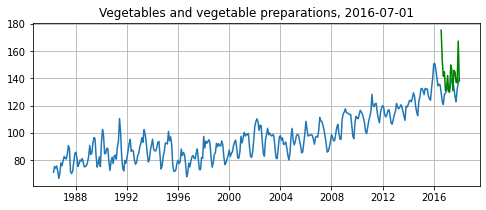

r2_score     -9.715
mae          13.529
mape          0.105
mse         322.763
rmse         17.966
dtype: float64
TRAINER:gluonts.mx.trainer._base.Trainer(add_default_callbacks=True, batch_size=16, callbacks=None, clip_gradient=10.0, ctx=mxnet.context.Context("cpu", 0), epochs=5, hybridize=True, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=10, patience=10, weight_decay=1e-08)


  0%|          | 0/10 [00:00<?, ?it/s]/home/ethan/anaconda3/envs/forecasting/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/ethan/anaconda3/envs/forecasting/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
  0%|          | 0/10 [00:00<?, ?it/s]/home/ethan/anaconda3/envs/forecasting/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
  0%|          | 0/10 [00:00<?, ?it/s]/home/ethan/anaconda3/envs/forecasting/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future vers

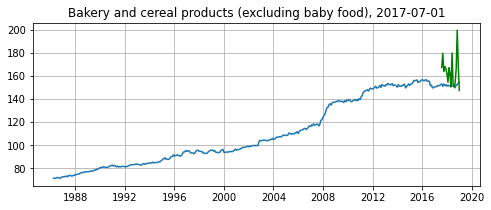

r2_score   -302.600
mae          13.570
mape          0.089
mse         313.992
rmse         17.720
dtype: float64


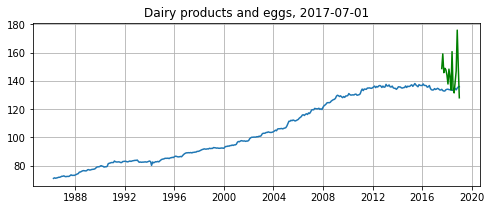

r2_score   -379.825
mae          12.997
mape          0.097
mse         269.116
rmse         16.405
dtype: float64


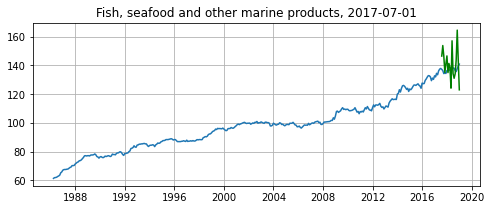

r2_score    -49.088
mae           9.179
mape          0.067
mse         134.968
rmse         11.618
dtype: float64


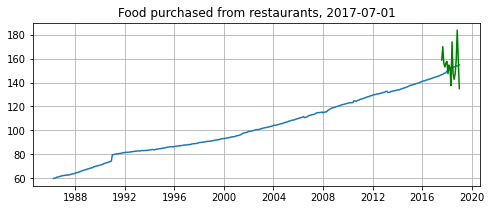

r2_score    -24.338
mae          10.633
mape          0.070
mse         175.291
rmse         13.240
dtype: float64


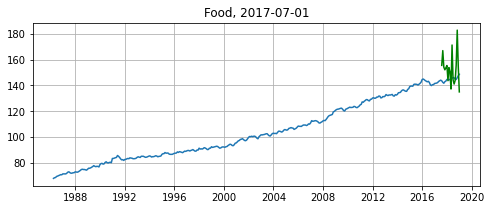

r2_score    -74.575
mae          11.437
mape          0.079
mse         212.367
rmse         14.573
dtype: float64


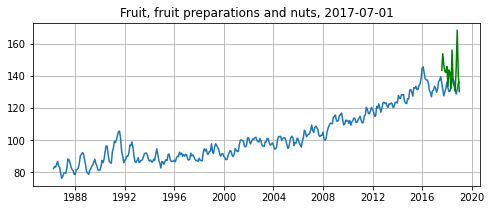

r2_score    -22.066
mae          10.896
mape          0.083
mse         202.905
rmse         14.244
dtype: float64


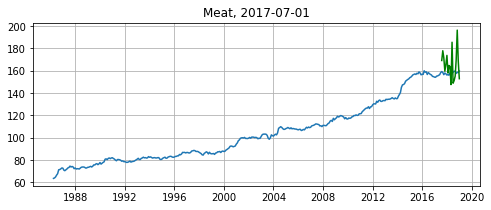

r2_score   -151.031
mae          11.894
mape          0.075
mse         220.468
rmse         14.848
dtype: float64


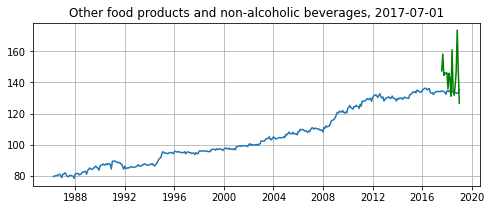

r2_score   -499.794
mae          12.228
mape          0.091
mse         244.910
rmse         15.650
dtype: float64


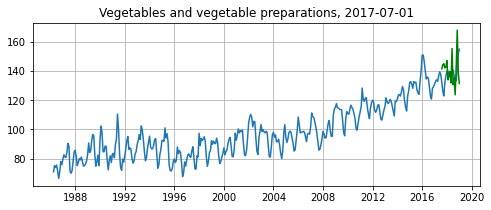

r2_score     -2.090
mae          10.758
mape          0.078
mse         169.112
rmse         13.004
dtype: float64
TRAINER:gluonts.mx.trainer._base.Trainer(add_default_callbacks=True, batch_size=16, callbacks=None, clip_gradient=10.0, ctx=mxnet.context.Context("cpu", 0), epochs=5, hybridize=True, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=10, patience=10, weight_decay=1e-08)


  0%|          | 0/10 [00:00<?, ?it/s]/home/ethan/anaconda3/envs/forecasting/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/ethan/anaconda3/envs/forecasting/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
  0%|          | 0/10 [00:00<?, ?it/s]/home/ethan/anaconda3/envs/forecasting/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
  0%|          | 0/10 [00:00<?, ?it/s]/home/ethan/anaconda3/envs/forecasting/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future vers

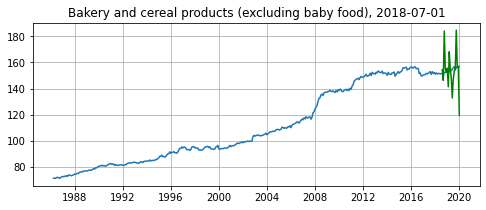

r2_score    -58.371
mae          10.100
mape          0.065
mse         237.089
rmse         15.398
dtype: float64


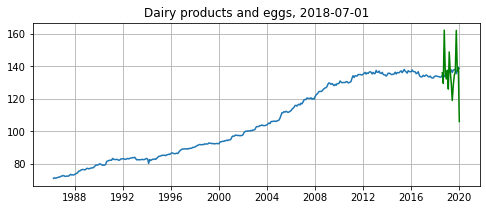

r2_score    -84.542
mae           9.221
mape          0.068
mse         188.720
rmse         13.738
dtype: float64


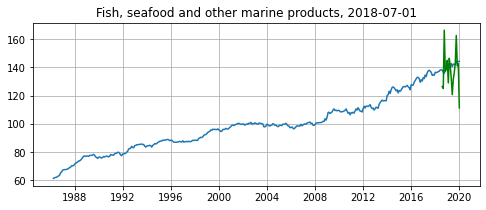

r2_score    -28.970
mae          10.146
mape          0.072
mse         196.602
rmse         14.021
dtype: float64


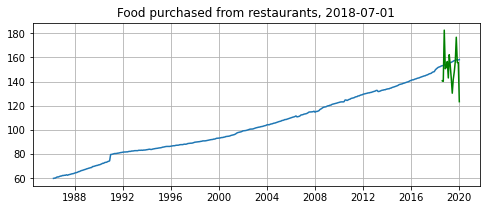

r2_score    -75.440
mae          11.388
mape          0.073
mse         228.348
rmse         15.111
dtype: float64


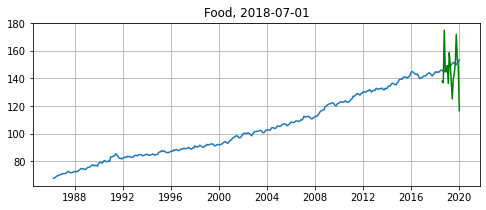

r2_score    -38.284
mae          10.921
mape          0.073
mse         231.591
rmse         15.218
dtype: float64


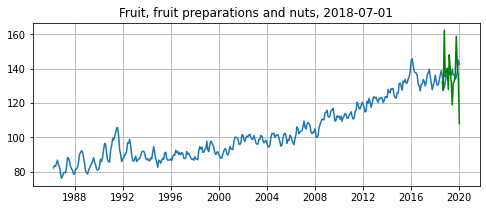

r2_score    -14.753
mae          10.132
mape          0.074
mse         208.049
rmse         14.424
dtype: float64


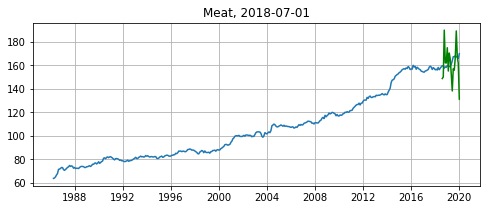

r2_score    -14.249
mae          12.172
mape          0.075
mse         259.502
rmse         16.109
dtype: float64


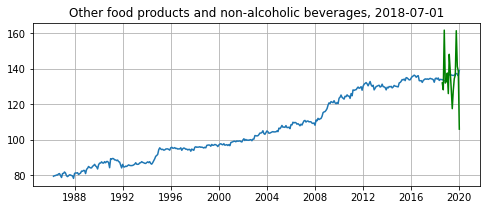

r2_score    -68.154
mae           9.185
mape          0.067
mse         182.183
rmse         13.498
dtype: float64


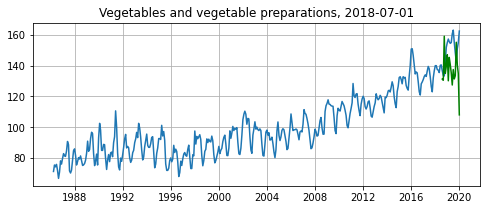

r2_score     -4.773
mae          18.177
mape          0.118
mse         475.809
rmse         21.813
dtype: float64
TRAINER:gluonts.mx.trainer._base.Trainer(add_default_callbacks=True, batch_size=16, callbacks=None, clip_gradient=10.0, ctx=mxnet.context.Context("cpu", 0), epochs=5, hybridize=True, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=10, patience=10, weight_decay=1e-08)


  0%|          | 0/10 [00:00<?, ?it/s]/home/ethan/anaconda3/envs/forecasting/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/ethan/anaconda3/envs/forecasting/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
  0%|          | 0/10 [00:00<?, ?it/s]/home/ethan/anaconda3/envs/forecasting/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
  0%|          | 0/10 [00:00<?, ?it/s]/home/ethan/anaconda3/envs/forecasting/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future vers

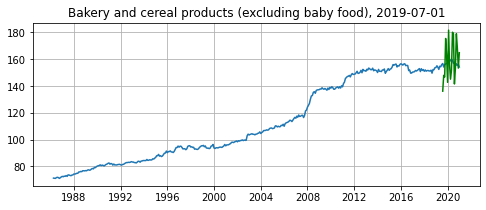

r2_score    -79.817
mae          13.060
mape          0.083
mse         221.510
rmse         14.883
dtype: float64


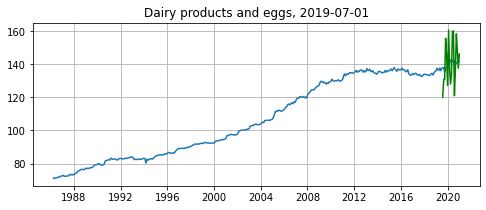

r2_score    -41.004
mae          11.552
mape          0.082
mse         176.717
rmse         13.294
dtype: float64


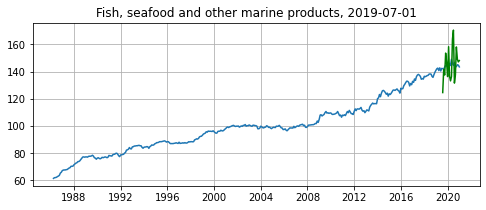

r2_score    -54.239
mae          10.080
mape          0.070
mse         143.928
rmse         11.997
dtype: float64


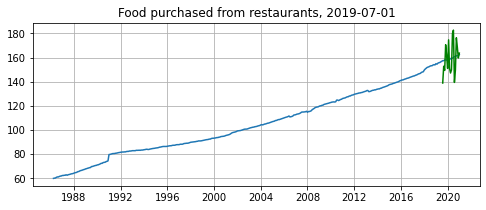

r2_score    -62.680
mae          11.149
mape          0.070
mse         166.686
rmse         12.911
dtype: float64


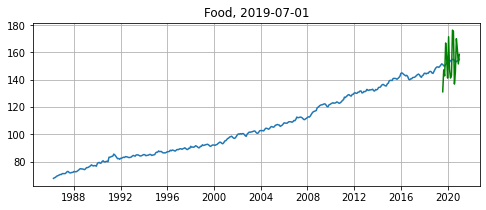

r2_score    -73.011
mae          11.513
mape          0.075
mse         173.370
rmse         13.167
dtype: float64


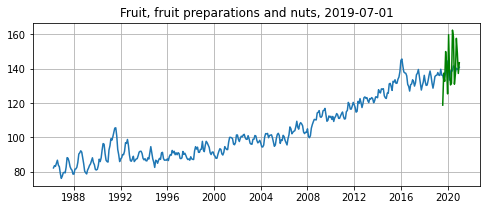

r2_score    -17.235
mae          10.151
mape          0.073
mse         154.287
rmse         12.421
dtype: float64


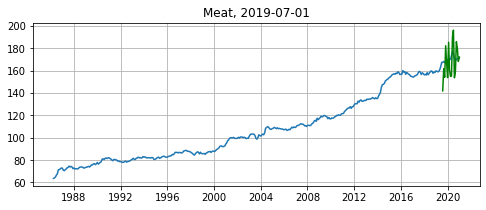

r2_score    -24.259
mae          12.492
mape          0.073
mse         201.072
rmse         14.180
dtype: float64


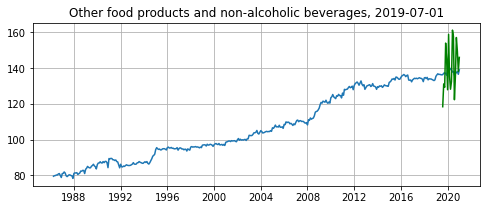

r2_score   -145.548
mae          11.655
mape          0.085
mse         180.181
rmse         13.423
dtype: float64


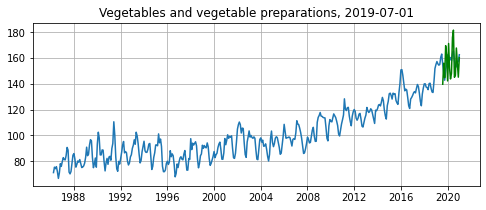

r2_score     -3.637
mae          10.704
mape          0.068
mse         145.867
rmse         12.078
dtype: float64
TRAINER:gluonts.mx.trainer._base.Trainer(add_default_callbacks=True, batch_size=16, callbacks=None, clip_gradient=10.0, ctx=mxnet.context.Context("cpu", 0), epochs=5, hybridize=True, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=10, patience=10, weight_decay=1e-08)


  0%|          | 0/10 [00:00<?, ?it/s]/home/ethan/anaconda3/envs/forecasting/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/ethan/anaconda3/envs/forecasting/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
  0%|          | 0/10 [00:00<?, ?it/s]/home/ethan/anaconda3/envs/forecasting/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
  0%|          | 0/10 [00:00<?, ?it/s]/home/ethan/anaconda3/envs/forecasting/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future vers

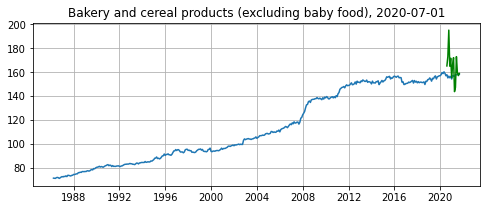

r2_score   -138.927
mae          11.176
mape          0.071
mse         214.460
rmse         14.644
dtype: float64


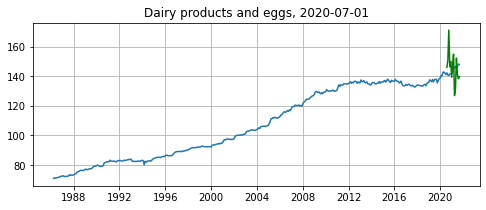

r2_score    -20.796
mae          10.017
mape          0.070
mse         152.276
rmse         12.340
dtype: float64


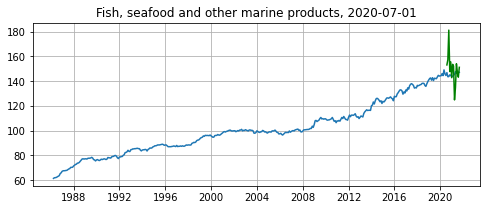

r2_score    -91.448
mae           9.828
mape          0.068
mse         183.633
rmse         13.551
dtype: float64


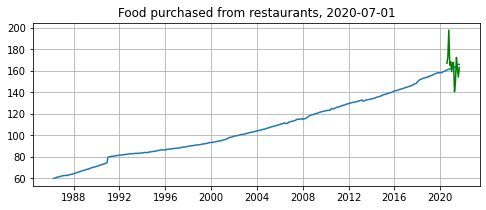

r2_score    -64.230
mae           9.998
mape          0.061
mse         181.527
rmse         13.473
dtype: float64


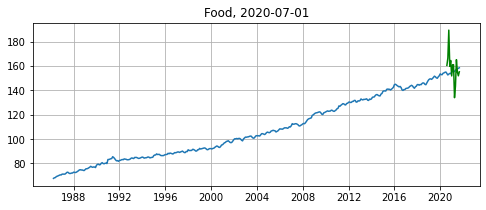

r2_score    -54.827
mae          10.154
mape          0.066
mse         179.820
rmse         13.410
dtype: float64


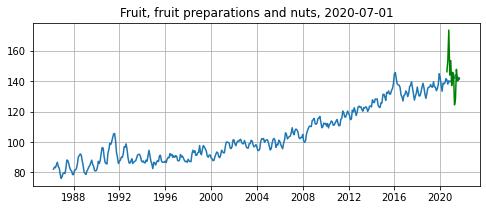

r2_score    -53.729
mae           8.668
mape          0.062
mse         156.112
rmse         12.494
dtype: float64


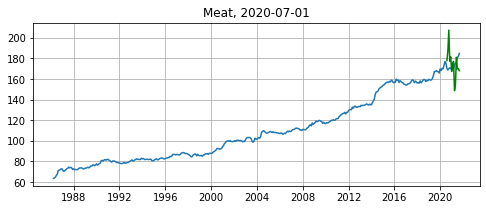

r2_score     -9.189
mae          13.386
mape          0.077
mse         260.882
rmse         16.152
dtype: float64


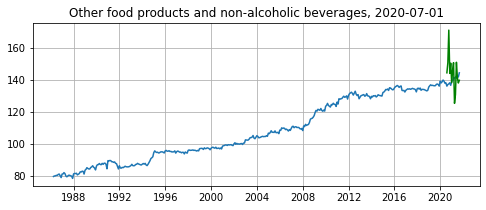

r2_score    -25.487
mae           9.704
mape          0.070
mse         157.408
rmse         12.546
dtype: float64


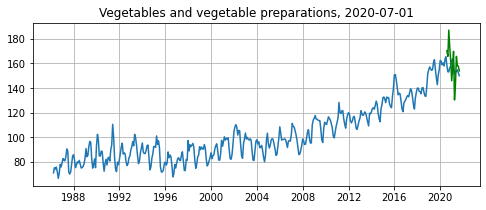

r2_score    -12.961
mae          12.299
mape          0.079
mse         212.324
rmse         14.571
dtype: float64


In [20]:
all_valid_metrics = {}
all_forecasts = {}

for report_sim_date in report_sim_dates:
    valid_metrics, forecasts = train_eval_nbeats(report_sim_date)
    all_valid_metrics[report_sim_date] = valid_metrics
    all_forecasts[report_sim_date] = forecasts

In [21]:
valid_metrics_concat = {}

all_valid_metrics.keys()

for report_date, valid_scores in all_valid_metrics.items():
    valid_metrics_concat[report_date] = pd.DataFrame(valid_scores).T
index = valid_metrics_concat[report_date].index
columns = valid_metrics_concat[report_date].columns
scores = [df.values for date, df in valid_metrics_concat.items()]
mean_scores = pd.DataFrame(np.array(scores).mean(axis=0), index=index, columns=columns)
mean_scores.to_csv(f"{output_path}/mean_fc_valid_metrics.csv")
mean_scores

,r2_score,mae,mape,mse,rmse
Bakery and cereal products (excluding baby food),-147.397,13.389,0.087,302.305,17.216
Dairy products and eggs,-204.296,12.305,0.090,249.262,15.570
"Fish, seafood and other marine products",-47.140,10.080,0.073,177.428,13.272
Food purchased from restaurants,-67.539,11.259,0.074,206.062,14.301
Food,-83.587,11.571,0.079,224.615,14.922
"Fruit, fruit preparations and nuts",-24.111,10.954,0.081,217.643,14.627
Meat,-77.548,12.762,0.078,255.525,15.923
Other food products and non-alcoholic beverages,-226.826,11.553,0.085,226.268,14.925
Vegetables and vegetable preparations,-6.148,13.428,0.093,282.818,16.449


## Fit Models Using All Data To Produce Final Forecast

## Predicted Change in CPI By Category

For the report, we usually express forecasts as the predicted percentage change, overall for the next year. We can do this by comparing the mean forecasted CPI for 2022 to the mean (known and predicted) values for 2021.